## Here, I am estimating the horizontal and vertical scales of Topographic Rossby Waves at the OSNAP array

In [6]:
from aux_funcs import *

Use dispersion relation:

## $ \sigma = \frac{- \alpha S^{1/2} k}{K tanh(K S^{1/2})} $

to estimate k for a range of frequencies $\sigma$.

where

### $ K^2 = k^2 + l^2$

Use a fixed relationship between k and l found from variance ellipses, k = 1.6 x l to simplify dispersion relation:

In [7]:
sqrt(1+1.6**2)

1.886796226411321

## $K=1.89k$

## $ \sigma = \frac{- \alpha S^{1/2}}{1.89 tanh(1.89k S^{1/2})} $

### $S^{1/2} = \frac{N_s D}{f_0 L}$

Calculate bathymetric slope for various smoothnesses

In [8]:
import scipy.signal as sig

In [294]:
Dmoor={}
#get deepest measurement point at each mooring
for dd in range(len(dat.distance)):
    Dmoor[dd+1]=dat.depth[where(isnan(dat['salinity'].mean(dim='date').isel(distance=dd))==False)[0][-1]].values
#     Dmoor[dd+1]=1000

In [301]:
def smslope(skipnum):
    alpha={}
    N  = 2    # Filter order
    Wn = 1/skipnum # Cutoff frequency
    B, A = sig.butter(N, Wn, output='ba')
    bathsm=-sig.filtfilt(B,A,bathbath)
    difdist=bathdist[:-1]+diff(bathdist)/2
    slope=diff(bathsm)/diff(bathdist)/1e3
    figure(figsize=(12,4))
    subplot(121)
    suptitle(str(skipnum*0.1)+'km filter')
    plot(bathdist,bathsm)
    for ii,dd in enumerate(distvec[3:]):
        plot(dd,-Dmoor[ii+4],'ro')
    xlabel('distance [km]')
    ylabel('depth')
    subplot(122)
    plot(difdist,slope)
    #find slope value closest to CF4-8
    slopef=interpolate.interp1d(difdist,slope)
    for ii,dd in enumerate(distvec[3:]):
        print('CF'+str(ii+4)+': '+str('{:5.2f}'.format(slopef(dd))))
        alpha[ii+4]=slopef(dd)
        plot(dd,slopef(dd),'ro')
    xlabel('distance [km]')
    ylabel('slope')
    return alpha

CF4: -0.10
CF5: -0.21
CF6: -0.00
CF7: -0.01
CF8: -0.02


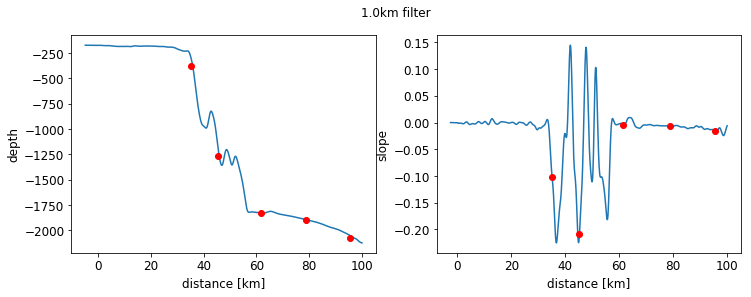

In [302]:
na=smslope(10)

Using 10km filter for alpha for now

CF4: -0.07
CF5: -0.05
CF6: -0.01
CF7: -0.01
CF8: -0.01


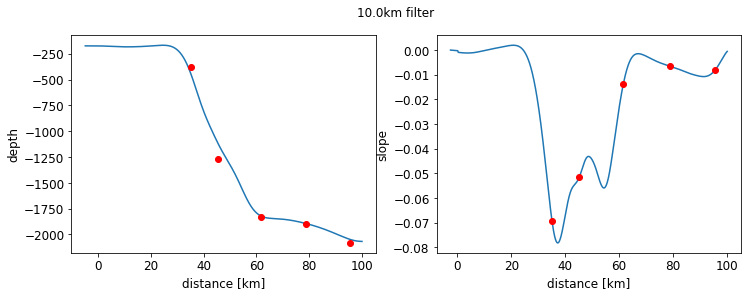

In [303]:
slope=smslope(100)
savefig('../figures/VertModes/bathyslope.pdf')

In [304]:
# for ii in slope:
# #     slope[ii]=-0.02

In [264]:
slope

{4: array(-0.06951162),
 5: array(-0.0513409),
 6: array(-0.01364645),
 7: array(-0.00650521),
 8: array(-0.00824888)}

In [265]:
#Choose some sensible dimensionalizing $D$ and $L$ and $f_0$
D=100
L=10e3
U=1
f0=sw.f(60)

In [267]:
alpha_ndim={}
for ii in slope:
    alpha_ndim[ii]=-slope[ii]*L**2*f0/U/Dmoor[ii]

In [268]:
alpha_ndim

{4: 0.8779396933548383,
 5: 0.6484414169777657,
 6: 0.17235625207666244,
 7: 0.08216156392355717,
 8: 0.10418431247558592}

Get stratification

In [269]:
dat=pickle.load(open('../pickles/xarray/CF_xarray_notid_1803extrap.pickle','rb'))

In [270]:
dat

<xarray.Dataset>
Dimensions:                (date: 712, depth: 1057, distance: 8)
Coordinates:
  * distance               (distance) int64 0 12 22 35 45 61 78 95
  * depth                  (depth) float64 0.0 1.981 3.962 5.943 7.924 9.905 ...
  * date                   (date) datetime64[ns] 2014-08-17 2014-08-18 ...
Data variables:
    temperature            (distance, depth, date) float64 -1.709 0.474 ...
    salinity               (distance, depth, date) float64 31.84 32.1 32.29 ...
    potential density      (distance, depth, date) float64 25.61 25.75 25.97 ...
    across track velocity  (distance, depth, date) float64 -0.4392 -0.3247 ...
    along track velocity   (distance, depth, date) float64 0.06316 -0.1438 ...

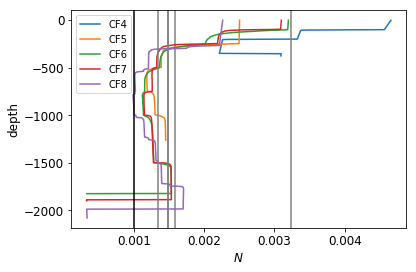

In [313]:
N={}
for ii in range(3,8):
    [N2all,na,ptwn]=sw.bfrq(dat['salinity'][ii,:,:].mean(dim='date'),dat['temperature'][ii,:,:].mean(dim='date'),dat.depth)
    plot(sqrt(N2all),-ptwn,label='CF'+str(ii+1))
    ylabel('depth')
    xlabel('$N$')
    N[ii+1]=nanmean(sqrt(N2all))
    axvline(N[ii+1],color='grey')
legend()
axvline(sqrt(1e-6),color='k')
savefig('../figures/VertModes/Nstrat.pdf',bbox_inches='tight')

In [272]:
N2

{4: 1.1352152578638357e-05,
 5: 2.714198707163763e-06,
 6: 2.4818327911170864e-06,
 7: 2.4178522310942623e-06,
 8: 2.021312733293649e-06}

In [273]:
# N2['small']=1e-6

Get nondim $S$

In [274]:
sqrtS={}
for ii in N2:
    sqrtS[ii]=N[ii]*Dmoor[ii]/f0/L
#     N[ii]=sqrt(1e-6)

In [275]:
slope

{4: array(-0.06951162),
 5: array(-0.0513409),
 6: array(-0.01364645),
 7: array(-0.00650521),
 8: array(-0.00824888)}

In [276]:
sqrtS

{4: 2.667668265539033,
 5: 1.3044082361139009,
 6: 1.2473231184794535,
 7: 1.2311404205279928,
 8: 1.125665792318946}

Look at 30-80 day period motions

In [277]:
def days2frq(days):
    sigma_ndim=(2*pi)/(days*24*60**2)*L/U
    return sigma_ndim

In [278]:
def days2frq_dim(days):
    sigma=(2*pi)/(days*24*60**2)
    return sigma

Solve for k:

## $ \sigma = \frac{- \alpha S^{1/2}}{1.89 tanh(1.89k S^{1/2})} $

## $ tanh(1.89k S^{1/2}) = \frac{- \alpha S^{1/2} }{1.89 \sigma } $

Solve above eqn

## $ k= tanh ^{-1} \Big( \frac{- \alpha S^{1/2} }{1.89 \sigma } \Big)/(1.89 S^{1/2})$

Some confusion about dimensionality. Stars indicate var with dims (plus N has dims)

## $S^{1/2} = \frac{N D}{f_0 L}$
## $\alpha = \alpha^* \frac{f_0 L^2}{U D}$
## $\sigma = \sigma^* \frac{L}{U}$
## $k^* = k/L$

## $ k^* L = k = tanh ^{-1} \Big( \frac{- \alpha^* \frac{f_0 L^2}{U D} \frac{N D}{f_0 L} }{1.89 \sigma^* L/U } \Big)/(1.89 \frac{N D}{f_0 L})$

## $ k^* L = k = tanh ^{-1} \Big( \frac{- \alpha^* N }{1.89 \sigma^* } \Big)/(1.89 \frac{N D}{f_0 L})$

## $ k^* = tanh ^{-1} \Big( \frac{- \alpha^* N }{1.89 \sigma^* } \Big)/(1.89 \frac{N D}{f_0})$

So, dimensional size of $k^*$ depends on $D$ and $f_0$

Solve for specific set of params

In [279]:
dayvec=hstack((arange(1,10),arange(10,100,10)))

In [280]:
Hlen_moor={}
Hlen_moor_dim={}
Vlen_moor_dim={}
k_moor={}
k_moor_dim={}
tanhmeat_moor={}
tanhmeat_moor_dim={}

for ii in sqrtS:
    k_moor[ii]=[(arctanh(-alpha_ndim[ii]*sqrtS[ii]/(1.89*days2frq(tt)))/1.89/sqrtS[ii]) for tt in dayvec]
    k_moor_dim[ii]=[(arctanh(-slope[ii]*N[ii]/(1.89*days2frq_dim(tt)))/1.89/(N[ii]*Dmoor[ii]/f0)) for tt in dayvec]
    Hlen_moor[ii]=[L*2*pi/1.89/zz/1e3 for zz in k_moor[ii]]
    Hlen_moor_dim[ii]=[2*pi/1.89/zz/1e3 for zz in k_moor_dim[ii]]
    Vlen_moor_dim[ii]=[zz*1e3*f0/N[ii]/2/pi for zz in Hlen_moor_dim[ii]]
    tanhmeat_moor[ii]=[-alpha_ndim[ii]*sqrtS[ii]/(1.89*days2frq(tt))for tt in dayvec]
    tanhmeat_moor_dim[ii]=[-slope[ii]*N[ii]/(1.89*days2frq_dim(tt))for tt in dayvec]

/home/isabela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arctanh
  # Remove the CWD from sys.path while we load stuff.
/home/isabela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arctanh
  # This is added back by InteractiveShellApp.init_path()


For solution to exist, 
## $|\frac{ \alpha^* N }{1.89 \sigma^* }| <=1$

In [281]:
savename='Dconstonly'

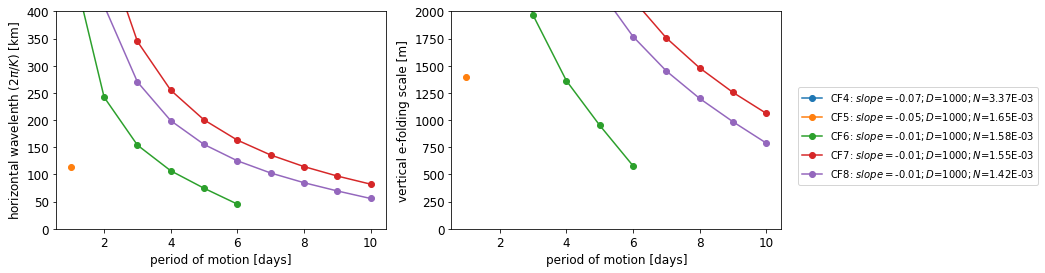

In [282]:
figure(figsize=(13,4))
subplot(121)
for ii in k_moor:
    plot(dayvec,Hlen_moor_dim[ii],'o-',label='CF'+str(ii)+': $slope=$'+str('{:5.2f}'.format(slope[ii]))+
                                                                           '$; D$='+str(int(Dmoor[ii]))+
                                                                                      '$; N$='+str('{:.2E}'.format(N[ii])))
ylim([0,400])
xlabel('period of motion [days]')
ylabel('horizontal wavelenth ($2 \pi / K$) [km]')

subplot(122)
for ii in k_moor:
    plot(dayvec,Vlen_moor_dim[ii],'o-',label='CF'+str(ii)+': $slope=$'+str('{:5.2f}'.format(slope[ii]))+
                                                                           '$; D$='+str(int(Dmoor[ii]))+
                                                                                      '$; N$='+str('{:.2E}'.format(N[ii])))
ylim([0,2e3])
legend(loc=(1.05,0.2))
xlabel('period of motion [days]')
ylabel('vertical e-folding scale [m]')
savefig('../figures/VertModes/estscales_'+savename+'.png',bbox_inches='tight')
savefig('../figures/VertModes/estscales_'+savename+'.pdf',bbox_inches='tight')

In [157]:
dayvec

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 20, 30, 40, 50, 60, 70, 80,
       90])

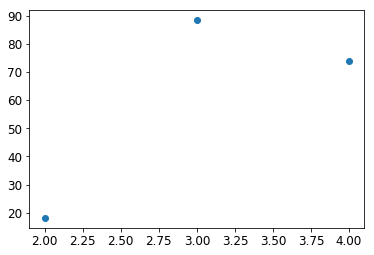

In [83]:
plot([Hlen_moor_dim[ii] for ii in k_moor],'o') 

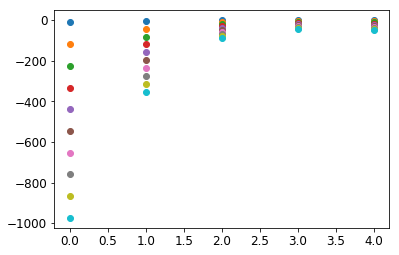

In [213]:
plot([tanhmeat_moor[ii] for ii in k_moor],'o') 

Construct vectors and explore param space

In [86]:
alpha_ndim

{4: 87.79396933548384,
 5: 64.84414169777656,
 6: 17.235625207666242,
 7: 8.216156392355717,
 8: 10.41843124755859}

In [87]:
sqrtS

{4: 0.2667668265539033,
 5: 0.1304408236113901,
 6: 0.12473231184794535,
 7: 0.12311404205279927,
 8: 0.11256657923189459}

In [90]:
# alphavec=arange(0.01,1.1,0.05)
alphavec=arange(10,100,10)

In [91]:
alphavec

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [97]:
sqrtS

{4: 0.2667668265539033,
 5: 0.1304408236113901,
 6: 0.12473231184794535,
 7: 0.12311404205279927,
 8: 0.11256657923189459}

In [94]:
sqrtSvec=arange(0.1,0.3,0.025)

In [95]:
sqrtSvec

array([0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275])

In [98]:
days2frq(10)

0.11574074074074074

In [99]:
days2frq(100)

0.011574074074074073

In [100]:
sigvec=arange(0.01,0.12,0.01)

In [101]:
sigvec

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11])

In [102]:
tanhmeat=zeros((len(alphavec),len(sqrtSvec),len(sigvec)))
ksol=zeros((len(alphavec),len(sqrtSvec),len(sigvec)))

In [103]:
for ii,aa in enumerate(alphavec):
    for jj,bb in enumerate(sqrtSvec):
        for kk,cc in enumerate(sigvec):
            tanhmeat[ii,jj,kk]=-aa*bb/(1.89*cc)
            ksol[ii,jj,kk]=arctanh(-aa*bb/(1.89*cc))/1.89/bb

/home/isabela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arctanh
  """


(-10, 0)

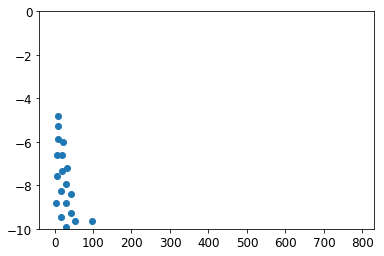

In [104]:
plot(tanhmeat.flatten(),'o')
ylim([-10,0])

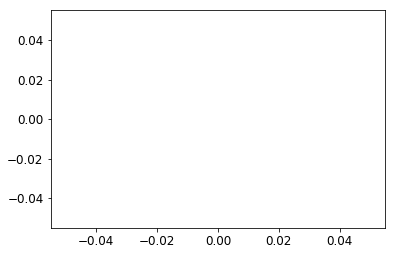

In [105]:
plot(ksol.flatten(),'o')

In [69]:
1/0.3

3.3333333333333335